In [1]:
from micrograd.optim import Adam, SGD
import micrograd.nn as nn
from tqdm import tqdm
import numpy as np
from dataset import regress_gaussian
import matplotlib.pyplot as plt

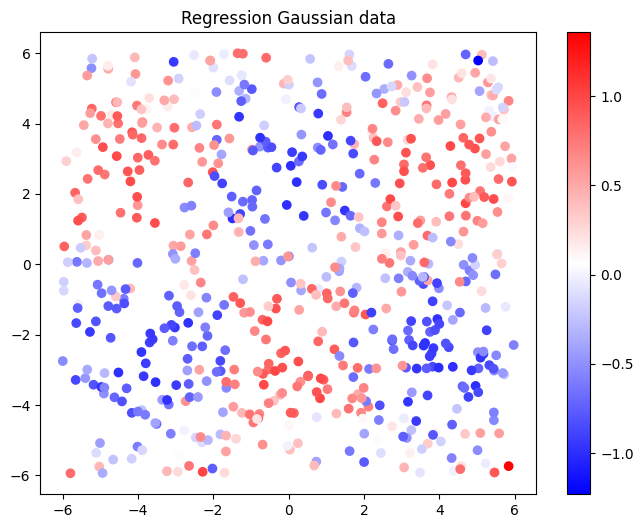

In [2]:
num_samples = 640
noise = 0.2
x, y, label = regress_gaussian(num_samples, noise)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=label, cmap=plt.cm.bwr)
plt.title('Regression Gaussian data')
plt.colorbar()
plt.show()

In [3]:
def get_loader(x, y, label, batch_size=32):
    num_samples = len(x)
    indices = np.random.permutation(num_samples)
    x = x[indices]
    y = y[indices]
    label = label[indices]
    # label = (label + 1) / 2 # for binary classification
    # label = label.astype(np.int32)
    for i in range(0, num_samples, batch_size):
        yield x[i:i+batch_size], y[i:i+batch_size], label[i:i+batch_size]

In [4]:

class MLP(nn.Module):
    def __init__(self, input_dim:int, hidden_dim:int, output_dim:int):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        return self.fc3(x)
    
    def parameters(self):
        return self.fc1.parameters() + self.fc2.parameters() + self.fc3.parameters()

In [5]:
model = MLP(2, 8, 1)
# criterion = nn.CrossEntropyLoss() # for binary classification
criterion = nn.MSELoss() # for regression

learning_rate = 5e-2
n_epochs = 20
batch_size = 32
optimizer = Adam(model.parameters(), lr=learning_rate)
pbar = tqdm(total=n_epochs*(num_samples//batch_size), desc='Training')

losses = []
for epoch in range(n_epochs):
    for x_batch, y_batch, label_batch in get_loader(x, y, label, batch_size):
        datas = [[x, y] for x, y in zip(x_batch, y_batch)]
        labels = label_batch.tolist()
        # y_pred = [model(x) for x in datas] # for binary classification
        y_pred = [pred for x in datas for pred in model(x)]
        loss = criterion(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
        pbar.set_postfix({'loss': loss.data})
        pbar.update(1)
pbar.close()

Training: 100%|██████████| 400/400 [00:34<00:00, 11.64it/s, loss=0.214]


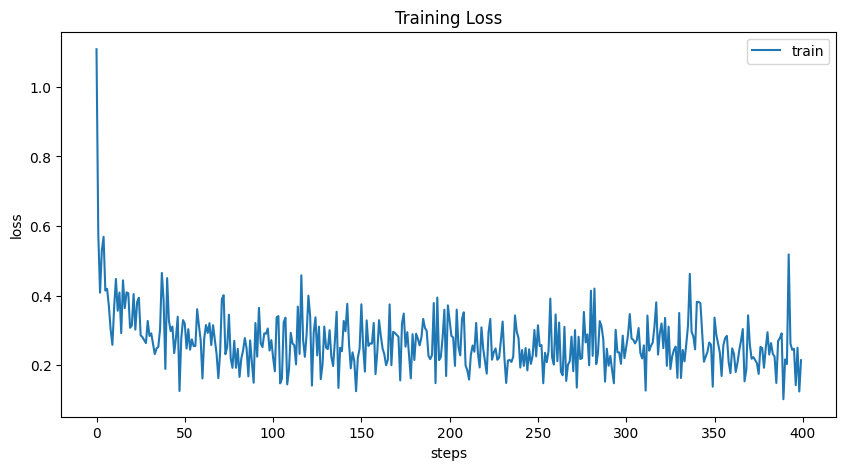

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label='train')
plt.legend()
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Training Loss')
plt.show()

In [7]:
from micrograd import Value
X = np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1)], axis=1)

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))

In [8]:
# Z = np.array([np.argmax([v.data for v in s]) for s in scores]) # for binary classification
Z = np.array([v.data for s in scores for v in s]) # for regression
Z = Z.reshape(xx.shape)

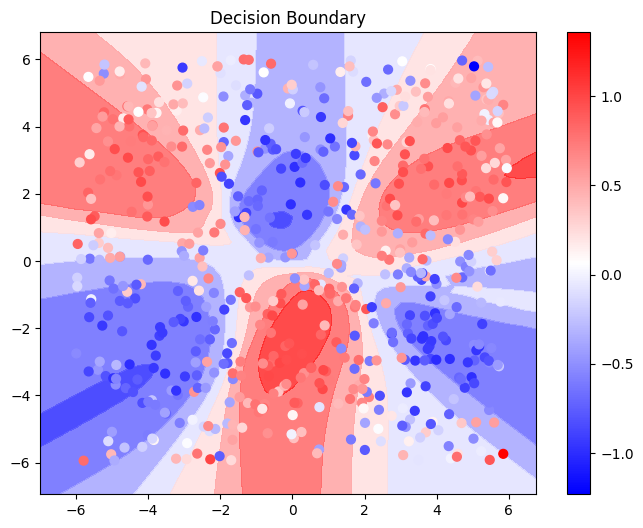

In [9]:
fig = plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.bwr, alpha=0.8)
plt.scatter(x, y, c=label, s=40, cmap=plt.cm.bwr)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Decision Boundary")
plt.colorbar()
plt.show()